In [2]:
from textblob import TextBlob
from search import SearchEngine
from article import ArticleParser
from datetime import datetime, timedelta
from xml.etree.ElementTree import ElementTree, fromstring
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def generate_search_urls(
    search_term: str,
    start: datetime,
    end: datetime) -> list[str]:
    """
    Generates a search URL for the given search term and start and end date
    Used for sentiment analysis over time
    """
    if start and not end:
        # no to date, default to a timeframe of 10 days
        end = start + timedelta(days=10)
    elif end and not start:
        # no from date, default to a timeframe of 10 days
        start = end - timedelta(days=10)
    elif not end and not start:
        # neither exist, default to a timeframe of the past 10 days
        end = datetime.today()
        start = end - timedelta(days=10)

    delta = end - start

    # for every day in the range, generate a search URL for the same topic

    # specifying "pointers" to the start and end date
    from_date = start
    to_date = start + timedelta(days=1)

    urls = []

    for _ in range(delta.days):
        time_filter = f'after:{from_date.strftime("%Y-%m-%d")} before:{to_date.strftime("%Y-%m-%d")}'
        urls.append(f'https://news.google.com/rss/search?q={search_term}+{time_filter}&hl=en-GB&gl=GB&ceid=GB:en')
        from_date = to_date
        to_date = to_date + timedelta(days=1)

    return urls

In [4]:
urls = generate_search_urls("robbery", (datetime.today() - timedelta(days=10)).date(), (datetime.today()).date())

In [5]:
def get_x_news(
    urls: list[str],
    items: int) -> list[list[ArticleParser]]:
    """
    Searches Google News for the given search term, and returns the number of news items specified. 
    """
    articles = []
    for i in range(0, len(urls)):
        response = requests.get(urls[i])
        root = fromstring(response.text)
        news_items = []
        all_items = root.findall('.//channel/item')
        for j in range(items):
            article = ArticleParser(all_items[j])
            news_items.append(article)
        articles.append(news_items)
    return articles

In [6]:
articles = get_x_news(urls, 5)

In [7]:
articles

[[<article.ArticleParser at 0x14944dfd0>,

In [8]:
def analyse_polarity(
        articles: list[list[ArticleParser]]) -> list[float]:
    """Analyses and averages the sentiment over each day, and returns a set of data points that can be used for plotting"""
    sentiments = []
    for art in articles:
        # we average the sentiment over the list art of articles
        print([a.sentiment for a in art])
        polarity = np.mean([a.sentiment[0] for a in art])
        sentiments.append(round(polarity, 2))
    return sentiments

In [9]:
polarities = analyse_polarity(articles)

[Sentiment(polarity=0.03829101610000486, subjectivity=0.3389196945376722), Sentiment(polarity=0.08430397727272727, subjectivity=0.24988162878787876), Sentiment(polarity=0.01083333333333333, subjectivity=0.22438095238095238), Sentiment(polarity=-0.08995098039215686, subjectivity=0.34950980392156855), Sentiment(polarity=0.015291269841269843, subjectivity=0.30564920634920634)]
[Sentiment(polarity=0.0, subjectivity=0.0), Sentiment(polarity=0.10476190476190476, subjectivity=0.2238095238095238), Sentiment(polarity=0.2066757803599909, subjectivity=0.4075814536340852), Sentiment(polarity=0.042857142857142864, subjectivity=0.2892857142857143), Sentiment(polarity=-0.06055555555555556, subjectivity=0.2116666666666667)]
[Sentiment(polarity=0.10476190476190476, subjectivity=0.2238095238095238), Sentiment(polarity=0.2433441558441558, subjectivity=0.4069196428571429), Sentiment(polarity=-0.04314574314574315, subjectivity=0.4189213564213565), Sentiment(polarity=0.09289272371464152, subjectivity=0.5051

In [10]:
polarities

[0.01, 0.06, 0.08, 0.06, 0.1, 0.09, 0.07, 0.04, 0.08, 0.08]

In [11]:
def generate_dates(start: datetime, end:datetime) -> list[str]:
    delta = timedelta(days=1)
    dates = []
    while start < end:
        start += delta
        dates.append(start.strftime('%m/%d/%Y'))
    return dates

In [12]:
dates = generate_dates((datetime.today() - timedelta(days=10)).date(), (datetime.today()).date())

In [13]:
dates

['07/22/2023',
 '07/23/2023',
 '07/24/2023',
 '07/25/2023',
 '07/26/2023',
 '07/27/2023',
 '07/28/2023',
 '07/29/2023',
 '07/30/2023',
 '07/31/2023']

In [14]:
# creating some sample data
column_names = ['date', 'polarity']
df=pd.DataFrame(np.transpose([dates, polarities]), columns=column_names)
print(df)

         date polarity
0  07/22/2023     0.01
1  07/23/2023     0.06
2  07/24/2023     0.08
3  07/25/2023     0.06
4  07/26/2023      0.1
5  07/27/2023     0.09
6  07/28/2023     0.07
7  07/29/2023     0.04
8  07/30/2023     0.08
9  07/31/2023     0.08


In [20]:
print(df.polarity)
df.polarity = df.polarity.astype(float)
print(df.polarity)

0    0.01
1    0.06
2    0.08
3    0.06
4    0.10
5    0.09
6    0.07
7    0.04
8    0.08
9    0.08
Name: polarity, dtype: float64
0    0.01
1    0.06
2    0.08
3    0.06
4    0.10
5    0.09
6    0.07
7    0.04
8    0.08
9    0.08
Name: polarity, dtype: float64


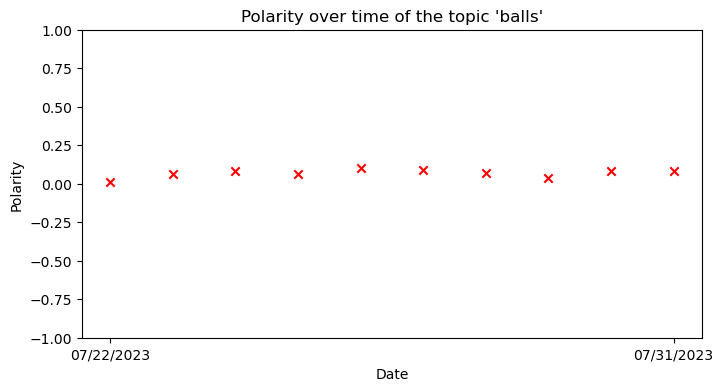

In [30]:
plt.figure(figsize=(8, 4))
plt.scatter(df['date'], df['polarity'], label='Polarity', marker='x', c='red')
plt.xlabel("Date")
plt.ylabel("Polarity")
plt.title(f"Polarity over time of the topic 'balls'")
plt.xticks([dates[0], dates[-1]])
plt.ylim(-1, 1)
plt.show()